In [47]:
import pandas as pd
import pickle
from tqdm import tqdm
from src.data.hex_utils import *

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
from pyproj import Transformer
import datetime
from shapely.ops import unary_union

In [62]:
def get_hex_traj(traj, n_rows, limits):
    size = get_hex_size(limits, n_rows)
    xys = hex_to_coords(traj, size, limits[0])
    hexagons = [
        patches.RegularPolygon(
            xy,
            numVertices=6,
            radius=size,
            orientation=np.radians(30),
            edgecolor="k",
            facecolor=(0.1, 0.2, 0.8, 0.5),
            linewidth=0.5,
        )
        for xy in xys
    ]

    return hexagons

def coords_to_hex(coords: np.ndarray, hex_size: float, coord_offset: np.ndarray):
    """Converts geo-coordinates to axial hexgrid coordinates

    Parameters
    ----------
    coords : np.ndarray
        Coordinates of shape (n, 2) to convert to match to hexgrid.
    hex_size : float
        Size of hexagons.

    Returns
    -------
    Axial coordinates of form [q, r]
    """
    pixels = coords - coord_offset
    a = np.array([[2, -1], [0, np.sqrt(3)]]) / 3
    fracs = pixels @ a / hex_size
    return cell_round(fracs)

def hex_to_coords(hex, hex_size, coord_offset):
    a = np.array([[1.5, 0], [0.5 * np.sqrt(3), np.sqrt(3)]])
    return (hex_size * a @ hex.T).T + coord_offset


def create_hexagon(center, size):
    angles = np.linspace(0, 2 * np.pi, 7)[:-1]
    hexagon = Polygon(
        [
            (center[0] + size * np.cos(angle), center[1] + size * np.sin(angle))
            for angle in angles
        ]
    )
    return hexagon


def get_hexgrid(limits, n_rows=None, size=None):
    if size is None:
        size = get_hex_size(limits, n_rows)
    xstep = 3 / 2 * size
    ystep = np.sqrt(3) * size

    x = np.arange(limits[0][0], limits[1][0], xstep)
    y = np.arange(limits[0][1], limits[1][1], ystep)

    n_cols, n_rows = len(x), len(y)
    xs, ys = np.meshgrid(x, y)
    xy = np.stack([xs, ys], axis=-1)
    odd_cols = np.arange(1, n_cols, 2)
    xy[:, odd_cols, 1] += ystep / 2
    xy = xy.reshape(-1, 2)

    hexagons = [create_hexagon(center, size) for center in xy]
    qr = coords_to_hex(xy, size, coord_offset=limits[0])

    gdf = gpd.GeoDataFrame(data=qr, columns=['q', 'r'] ,geometry=hexagons)
    return gdf


In [84]:
crs1 = "epsg:4326"
crs2 = "epsg:3857"
limits = np.array([[116.1, 39.7], [116.7, 40.1]])
patch = np.array([[116.4, 39.8], [116.5, 39.85]])
max_date = datetime.datetime(2008, 1, 1)
n_rows = 100

transformer = Transformer.from_crs(crs1, crs2)

with open("../data/processed/geolife.pkl", "rb") as f:
    gdf = pickle.load(f)

gdf = gdf[(gdf["datetime"] < max_date) & (gdf['lat'])]
lon, lat = transformer.transform(gdf["lat"], gdf["lon"])
gdf["lon"] = lon
gdf["lat"] = lat

lonlimit, latlimit = transformer.transform(limits[:, 1], limits[:, 0])
limits= np.array([lonlimit, latlimit]).T

lonpatch, latpatch = transformer.transform(patch[:, 1],patch[:, 0])
patch= np.array([lonpatch, latpatch]).T

hdf = hexagonize(gdf, n_rows=n_rows, limits=limits)
cells = hdf[['q', 'r']]
hdf['cell_dist'] = cell_distance(cells.values, cells.shift().values)
hdf['cell_dist'] = hdf['cell_dist'].fillna(1)
hdf = hdf[hdf['cell_dist'] >= 1]

In [85]:
# Create the hexagonal grid
size = get_hex_size(limits, n_rows)
grid = get_hexgrid(limits, size=size)
grid = grid.set_crs(crs2)
grid = grid.cx[patch[0, 0] : patch[1, 0], patch[0, 1] : patch[1, 1]]

# Get visit counts for each grid cell
n_cell_visits = hdf.groupby(["q", "r"]).size().reset_index()
n_cell_visits = n_cell_visits.rename(columns={0: "n_visits"})
grid = grid.merge(n_cell_visits, on=["q", "r"], how="left")
grid = grid.fillna(0)

# Get higher order coordinates
grid = grid.rename(columns={"q": "q0", "r": "r0"})
for level in tqdm(list(range(1, 4)), desc="Computing high-level cells..."):
    q_new, r_new = small_to_big(
        qr=grid[[f"q{level-1}", f"r{level-1}"]].values, radius=1
    ).T
    grid[f"q{level}"] = q_new
    grid[f"r{level}"] = r_new

Computing high-level cells...: 100%|██████████| 3/3 [00:00<00:00, 823.11it/s]


In [86]:
# Get number of visits for higher level cells
grids = [grid]
for level in list(range(1, 4)):
    result = (
        grid.groupby([f"q{level}", f"r{level}"])
        .agg({"geometry": unary_union, "n_visits": "sum"})
        .reset_index()
    )
    result = result.set_geometry("geometry")
    result = result.set_crs(crs2)
    grids.append(result)

IndexError: index 3 is out of bounds for axis 0 with size 3

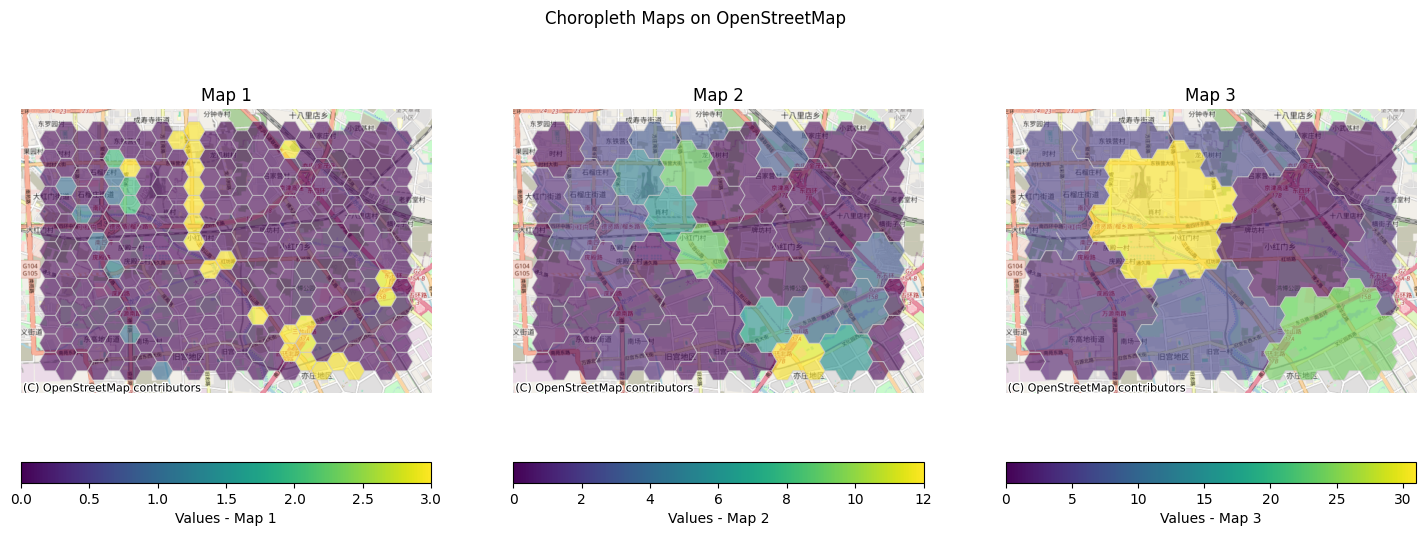

In [87]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Choropleth Maps on OpenStreetMap')

for i, gdf in enumerate(grids):
    # Ensure the GeoDataFrame is in Web Mercator projection
    gdf = gdf.to_crs(epsg=3857)
    
    # Create choropleth map
    # vmin, vmax = gdf['n_visits'].min(), gdf['n_visits'].max()
    # norm = Normalize(vmin=vmin, vmax=vmax)
    
    gdf.plot(column='n_visits', ax=axs[i], alpha=0.6, 
             edgecolor='0.8', linewidth=0.8,
             legend=True, 
            #  norm=norm,
             legend_kwds={'label': f'Values - Map {i+1}',
                          'orientation': 'horizontal'})
    
    # Add OpenStreetMap as background
    ctx.add_basemap(axs[i], source=ctx.providers.OpenStreetMap.Mapnik)
    
    # Remove axis
    axs[i].axis('off')
    
    # Set title
    axs[i].set_title(f'Map {i+1}')

plt.tight_layout()
plt.show()

In [42]:

grid['n_visits'].describe()

count    13534.000000
mean         1.185976
std          7.756562
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        474.000000
Name: n_visits, dtype: float64

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
padding = 1e-4

# Plot the line on the transformed coordinates
ax.plot(
    gdf["lon"],
    gdf["lat"],
    marker="o",
    markersize=0,
    color="red",
    linestyle="-",
    label="Path",
)


# Add the OpenStreetMap basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

n_rows = 100


grid_hexs = get_hex_traj(hdf[["q", "r"]].values, n_rows, limits)
for hexagon in grid_hexs + visited_hexs:
    ax.add_patch(hexagon)


ax.set_aspect("equal")
# ax.autoscale_view()
plt.axis("off")
# plt.show()

In [6]:
crs2 = "epsg:2333"
lonlimits = [116.1, 116.7]
latlimits = [39.7, 40.1]
n_rows = 100

limits = gpd.points_from_xy(x=lonlimits, y=latlimits, crs="epsg:4326")
limits = limits.to_crs(crs2)
size = get_hex_size(limits, n_rows)

grid = get_hexgrid(limits=limits, size=size)
grid_filtered = grid.merge(hex_traj, on=["q", "r"])
map = folium.Map(location=(40.2, 116.383331), zoom_start=8.2)
pgrid = grid.to_crs("epsg:4326")
grid_json = pgrid.to_json()
tooltip = folium.GeoJsonTooltip(fields=["q", "r"])


grid_layer = folium.GeoJson(
    grid_json,
    tooltip=tooltip,
)
grid_layer.add_to(map)
map

NameError: name 'hex_traj' is not defined